In [ ]:
import pandas as pd
import numpy as np
from notebook_functions import adstock, s_curve, create_transformed_tables, plot_stacked_area_with_actual, plot_transformed_vs_raw, plot_data_set
import pandas as pd

In [171]:
import matplotlib.pyplot as plt

def plot_stacked_area_with_actual(df_values, y_axis_min=None, y_axis_max=None):
    """
    Plots a stacked area chart for all variables except 'error' and 'actual' on the left y-axis,
    and plots 'actual' as a line on the right y-axis. Both axes share the same scale.
    y_axis_min, y_axis_max: set min/max for both y-axes. If None, use default.
    """
    # Select columns to plot (exclude 'error' and 'actual')
    cols = [col for col in df_values.columns if col not in ['error', 'actual']]
    x = df_values.index
    y = df_values[cols].values.T
    actual = df_values['actual'].values
    fig, ax1 = plt.subplots(figsize=(12, 6))
    # Stacked area plot
    ax1.stackplot(x, y, labels=cols)
    ax1.set_ylabel('Stacked Variables')
    ax1.set_xlabel('Date')
    ax1.legend(loc='upper left')
    # Plot actual on right y-axis
    ax2 = ax1.twinx()
    ax2.plot(x, actual, color='black', label='Actual', linewidth=2)
    ax2.set_ylabel('Actual')
    # Set same scale for both axes
    if y_axis_min is not None and y_axis_max is not None:
        ax1.set_ylim(y_axis_min, y_axis_max)
        ax2.set_ylim(y_axis_min, y_axis_max)
    else:
        min_y = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
        max_y = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
        ax1.set_ylim(min_y, max_y)
        ax2.set_ylim(min_y, max_y)
    ax2.legend(loc='upper right')
    plt.title('Stacked Area Chart of Variables with Actual as Line')
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_stacked_area_with_actual(df_values, y_axis_min=0, y_axis_max=100)

In [156]:
def adstock(x, rate):
    """
    Apply adstock transformation to a media variable.
    x: array-like, media spend or GRP
    rate: float, carryover rate between 0 and 1
    Returns: numpy array of adstocked values
    """
    result = np.zeros_like(x)
    for i in range(len(x)):
        if i == 0:
            result[i] = x[i]
        else:
            result[i] = x[i] + rate * result[i-1]
    return result

# Example usage:
# df_data['media1_adstock'] = adstock(df_data['media1'].values, 0.5)
# df_data.head()

In [164]:
import matplotlib.pyplot as plt
def plot_data_set(df):

    # Select columns to plot (excluding the constant column if present)
    cols_to_plot = [col for col in df.columns if col != 'c']
    n_cols = 2
    n_rows = int(np.ceil(len(cols_to_plot) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows), sharex=True)
    axes = axes.flatten()

    for i, col in enumerate(cols_to_plot):
        df[col].plot(ax=axes[i], title=col)
        axes[i].set_ylabel(col)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

In [148]:
import matplotlib.pyplot as plt
import numpy as np

def plot_transformed_vs_raw(raw, transformed, 
                            xlabel='Raw values', 
                            ylabel='Transformed values', title='Line Plot: Raw vs Transformed'):
    """
    Plots raw vs transformed values as a line, with raw values sorted ascending.
    """
    # Sort raw values and reorder transformed accordingly
    sort_idx = np.argsort(raw)
    raw_sorted = raw[sort_idx]
    transformed_sorted = transformed[sort_idx]
    plt.figure(figsize=(10, 6))
    plt.plot(raw_sorted, transformed_sorted, linestyle='-', marker=None)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()


In [157]:
def s_curve(grps, saturation, inflection, height):
    """
    Applies the transformation: arctan((grps**inflection)/(saturation**inflection)) / (pi/2) * height
    grps: array-like, input variable
    saturation, inflection, height: scalars
    Returns: numpy array of transformed values
    """
    return (np.arctan((grps ** inflection) / (saturation ** inflection)) / (np.pi / 2)) * height

# Example usage:
# df_data['media1_transformed'] = s_curve(df_data['media1'].values, saturation=1, inflection=1, height=1)
# df_data.head()

In [161]:
def create_transformed_tables(df_data, df_var_spec):
    """
    For each variable in df_var_spec, apply adstock (if carryover is not None), then s_curve (if saturation and inflection are not None),
    then multiply by beta. Returns df_trans and df_values tables, with df_values including an 'actual' column summing each row.
    """
    df_trans = pd.DataFrame(index=df_data.index)
    df_values = pd.DataFrame(index=df_data.index)
    for _, row in df_var_spec.iterrows():
        var = row['variable']
        if var in df_data.columns:
            series = df_data[var].values.copy()
            # Apply adstock if carryover is not None and not NaN
            if row.get('carryover') is not None and not pd.isnull(row['carryover']):
                series = adstock(series, row['carryover'])
            # Apply s_curve if saturation and inflection are not None and not NaN
            if (row.get('saturation') is not None and not pd.isnull(row['saturation']) and
                row.get('inflection') is not None and not pd.isnull(row['inflection'])):
                series = s_curve(series, row['saturation'], row['inflection'], height=1)
            df_trans[var] = series
            # Multiply by beta
            beta_val = row['beta'] if not pd.isnull(row['beta']) else 1
            df_values[var] = df_trans[var] * beta_val
        else:
            # If column missing, fill with NaN
            df_trans[var] = np.nan
            df_values[var] = np.nan
    # Add 'actual' column as row sum
    df_values['actual'] = df_values.sum(axis=1)
    return df_trans, df_values


## Create a DataFrame with 3 Years of Weekly Data
This cell generates a DataFrame with 156 weeks (3 years), where the first column is a cyclical variable based on a sine wave that repeats each year.

In [167]:
import pandas as pd
import numpy as np

# Number of years and weeks per year
years = 3
weeks_per_year = 52
n_weeks = years * weeks_per_year

# Generate week numbers
week = np.arange(n_weeks)

# Sine wave: one cycle per year
sine_wave = np.sin(2 * np.pi * (week % weeks_per_year) / weeks_per_year)

# Create date range starting from 1/1/22, weekly frequency
start_date = '2022-01-01'
dates = pd.date_range(start=start_date, periods=n_weeks, freq='W-SAT')

# Price pattern: repeat [5, 6, 5.5, 4] to fill n_weeks
price_pattern = [5,5,5,5,5,5,6,6,6,6,6,6,6,6,6,6,6,6,6,6,5.5,5.5,4,4,4,4,4,4,4,4,4,4,4,4]
price = np.resize(price_pattern, n_weeks)

distribution = np.full(n_weeks, 0.5)
distribution[n_weeks//2:] = 0.6

# Media variables: each is random 0-50 for a 3-month block, rest 0
media1 = np.zeros(n_weeks)
media2 = np.zeros(n_weeks)
media3 = np.zeros(n_weeks)

block_len = 13  # ~3 months (weeks)
media1[:block_len] = np.random.uniform(0, 50, block_len)
media2[block_len:2*block_len] = np.random.uniform(0, 50, block_len)
media3[2*block_len:3*block_len] = np.random.uniform(0, 50, block_len)

block_len = 8  # 2 months (weeks)
start_period = 52
media1[start_period:block_len+start_period] = np.random.uniform(0, 50, block_len)
media2[start_period+block_len:start_period+2*block_len] = np.random.uniform(0, 50, block_len)
media3[start_period+2*block_len:start_period+3*block_len] = np.random.uniform(0, 50, block_len)

start_period = 104
media1[start_period:block_len+start_period] = np.random.uniform(0, 50, block_len)
media2[start_period+block_len:start_period+2*block_len] = np.random.uniform(0, 50, block_len)
media3[start_period+2*block_len:start_period+3*block_len] = np.random.uniform(0, 50, block_len)

df_data = pd.DataFrame({
    'c':1,
    'cyclical_var': sine_wave,
    'price': price,
    'distribution': distribution,
    'media1': media1,
    'media2': media2,
    'media3': media3,
    'error':np.random.normal(0, 1, n_weeks)
}, index=dates)

df_data.head()

,c,cyclical_var,price,distribution,media1,media2,media3,error
2022-01-01,1,0.000000,5.0,0.5,45.983497,0.0,0.0,-0.797043
2022-01-08,1,0.120537,5.0,0.5,13.318866,0.0,0.0,0.457835
2022-01-15,1,0.239316,5.0,0.5,42.280876,0.0,0.0,1.789849
2022-01-22,1,0.354605,5.0,0.5,32.882223,0.0,0.0,-1.201223
2022-01-29,1,0.464723,5.0,0.5,7.266488,0.0,0.0,-0.611669


In [123]:
# Create a new DataFrame with specified columns and data types
df_var_spec = pd.DataFrame({
    'variable': pd.Series(dtype='str'),
    'beta': pd.Series(dtype='float'),
    'carryover': pd.Series(dtype='float'),
    'saturation': pd.Series(dtype='float'),
    'inflection': pd.Series(dtype='float'),
    'r3': pd.Series(dtype='float')
})
df_var_spec

,variable,beta,carryover,saturation,inflection,r3


In [176]:
# Clear all rows in df_var_spec before adding new rows
df_var_spec = df_var_spec.iloc[0:0]

# Explicitly add each column of df_data as a row in df_var_spec
df_var_spec = pd.concat([
    df_var_spec,
    pd.DataFrame([{'variable': 'c', 'beta': 100, 'carryover': None, 'saturation': None, 'inflection': None, 'r3': None}]),
    pd.DataFrame([{'variable': 'cyclical_var', 'beta': 1, 'carryover': None, 'saturation': None, 'inflection': None, 'r3': None}]),
    pd.DataFrame([{'variable': 'price', 'beta': -0.5, 'carryover': None, 'saturation': None, 'inflection': None, 'r3': None}]),
    pd.DataFrame([{'variable': 'distribution', 'beta': 1, 'carryover': None, 'saturation': None, 'inflection': None, 'r3': None}]),
    pd.DataFrame([{'variable': 'media1', 'beta': 1, 'carryover': 0.5, 'saturation': 5, 'inflection': 1, 'r3': None}]),
    pd.DataFrame([{'variable': 'media2', 'beta': 1, 'carryover': 0.7, 'saturation': 10, 'inflection': 1, 'r3': None}]),
    pd.DataFrame([{'variable': 'media3', 'beta': 1, 'carryover': 0.2, 'saturation': 15, 'inflection': 1.2, 'r3': None}]),
    pd.DataFrame([{'variable': 'error', 'beta': 1, 'carryover': None, 'saturation': None, 'inflection': None, 'r3': None}])
], ignore_index=True)

df_var_spec

C:\Users\User\AppData\Local\Temp\ipykernel_33732\3553287127.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_var_spec = pd.concat([


,variable,beta,carryover,saturation,inflection,r3
0,c,100.0,NaN,None,NaN,None
1,cyclical_var,1.0,NaN,None,NaN,None
2,price,-0.5,NaN,None,NaN,None
3,distribution,1.0,NaN,None,NaN,None
4,media1,1.0,0.5,5,1.0,None
5,media2,1.0,0.7,10,1.0,None
6,media3,1.0,0.2,15,1.2,None
7,error,1.0,NaN,None,NaN,None


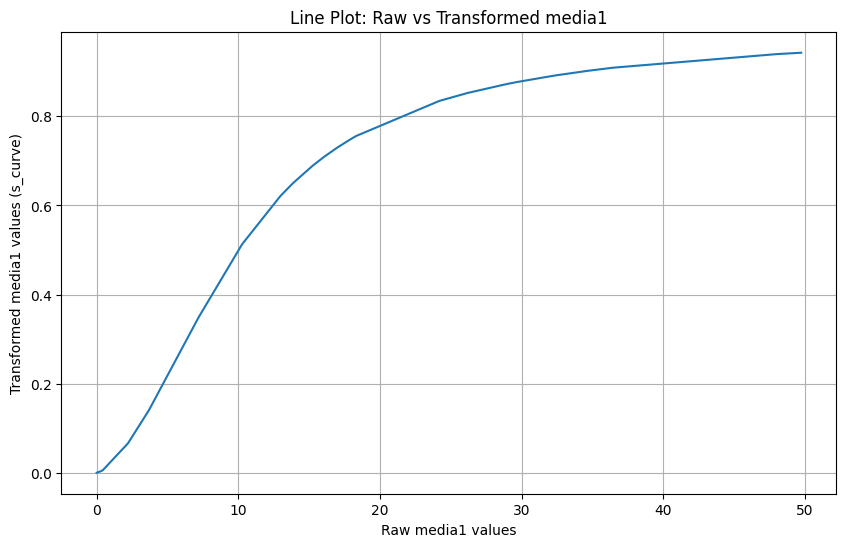

In [137]:
# Apply s_curve transformation to media1
media1_transformed = s_curve(df_data['media1'].values, saturation=10, inflection=1.5, height=1)

# Plot using the function
plot_transformed_vs_raw(df_data['media1'].values, media1_transformed, xlabel='Raw media1 values', ylabel='Transformed media1 values (s_curve)', title='Line Plot: Raw vs Transformed media1')

In [177]:
# Example usage:
df_trans, df_values = create_transformed_tables(df_data, df_var_spec)
# df_trans.head()

df_values.head()

,c,cyclical_var,price,distribution,media1,media2,media3,error,actual
2022-01-01,100.0,0.000000,-2.5,0.5,0.931048,0.0,0.0,-0.797043,98.134005
2022-01-08,100.0,0.120537,-2.5,0.5,0.912885,0.0,0.0,0.457835,99.491256
2022-01-15,100.0,0.239316,-2.5,0.5,0.947451,0.0,0.0,1.789849,100.976616
2022-01-22,100.0,0.354605,-2.5,0.5,0.949660,0.0,0.0,-1.201223,98.103042
2022-01-29,100.0,0.464723,-2.5,0.5,0.918446,0.0,0.0,-0.611669,98.771500


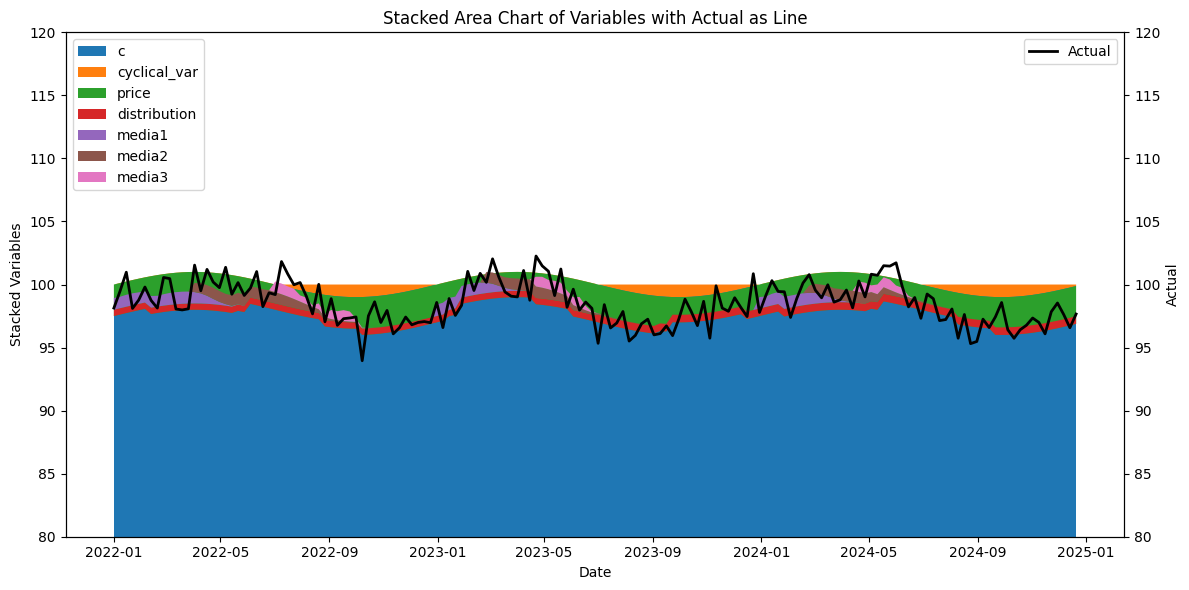

In [178]:
plot_stacked_area_with_actual(df_values, y_axis_min=80, y_axis_max=120)

In [179]:
import os

# Ensure Data folder exists
os.makedirs('Data', exist_ok=True)

# Save dataframes as CSV
if 'df_data' in globals():
    df_data.to_csv('Data/df_data.csv')
if 'df_trans' in globals():
    df_trans.to_csv('Data/df_trans.csv')
if 'df_values' in globals():
    df_values.to_csv('Data/df_values.csv')